*UID*: 120061660


# **CMSC426 Project 1: Color Segmentation using GMM**

# Introduction

Have you ever played with these adorable Nao robots? Click [here](http://www.youtube.com/watch?feature=player_embedded&v=Gy_wbhQxd_0) to watch a cool demo.

Nao robots are star players in RoboCup, an annual autonomous robot soccer competitions. Would you like to help us in Nao’s soccer training? We need to train Nao to detect a soccer ball and estimate the depth of the ball to know how far to kick.

Nao’s training has two phases:

- Color Segmentation using Gaussian Mixture Model (GMM)
- Ball Distance Estimation


<a name='problem'></a>
# What you need to do

To make logistics easier, we have collected camera data from Nao robot on behalf of you and saved the data in the form of color images. Click [here](https://drive.google.com/file/d/1k1dydl1Yho08isNg-_542fajXujybujH/view?usp=sharing) to download, or **run the following code block to download the training image folder to the file directory of the notebook**. The image names represent the depth of the ball from Nao robot in centimeters. -We will release the test dataset 48 hours before the deadline. **Test images are available [here](https://drive.google.com/file/d/1_qC1OnK58kYfBKZ9FUYnSmBLdfTpRmSr/view?usp=sharing) to download.**

In [25]:
# Download training images from Google Drive
import gdown
gdown.download_folder(id="18Mx2Xc9UNFZYajYu9vfmRFlFCcna5I0J", quiet=True, use_cookies=False)

FileURLRetrievalError: Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=19xcdUjqG89WzW5BSORBW-efEiBuouoVm

but Gdown can't. Please check connections and permissions.

In [2]:
# Download testing images from Google Drive
gdown.download_folder(id="1Yl4_5O_ZEkz_KJVs0_vS5TrZUqMYkwr4", quiet=True, use_cookies=False)

['/Users/amruthnare/Documents/Classes/CMSC426/426-project-1/test_images/1.jpg',
 '/Users/amruthnare/Documents/Classes/CMSC426/426-project-1/test_images/2.jpg',
 '/Users/amruthnare/Documents/Classes/CMSC426/426-project-1/test_images/3.jpg',
 '/Users/amruthnare/Documents/Classes/CMSC426/426-project-1/test_images/4.jpg',
 '/Users/amruthnare/Documents/Classes/CMSC426/426-project-1/test_images/5.jpg',
 '/Users/amruthnare/Documents/Classes/CMSC426/426-project-1/test_images/6.jpg',
 '/Users/amruthnare/Documents/Classes/CMSC426/426-project-1/test_images/7.jpg',
 '/Users/amruthnare/Documents/Classes/CMSC426/426-project-1/test_images/8.jpg']

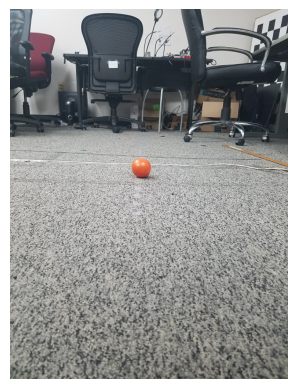

In [3]:
# Check whether the training images were successfully imported
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

train_image = mpimg.imread('./train_images/106.jpg')
plt.imshow(train_image)
plt.axis("off")
plt.show()

## Problem Statement

1. Write Python code to cluster the orange ball using [Single Gaussian](https://cmsc426.github.io/colorseg/#gaussian) [30 points]

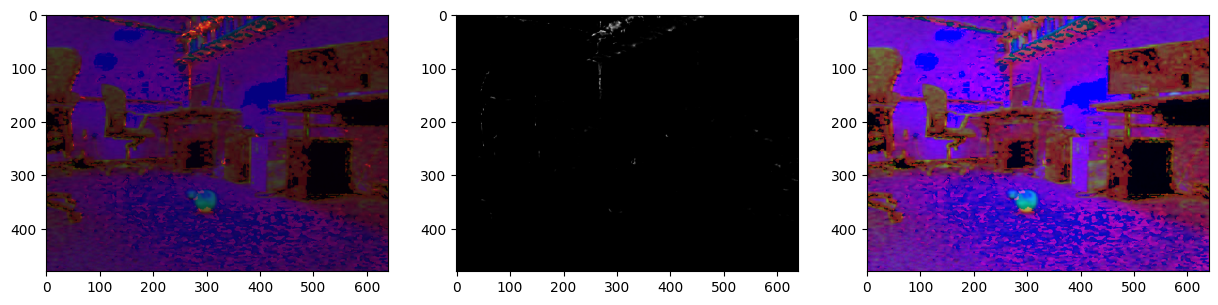

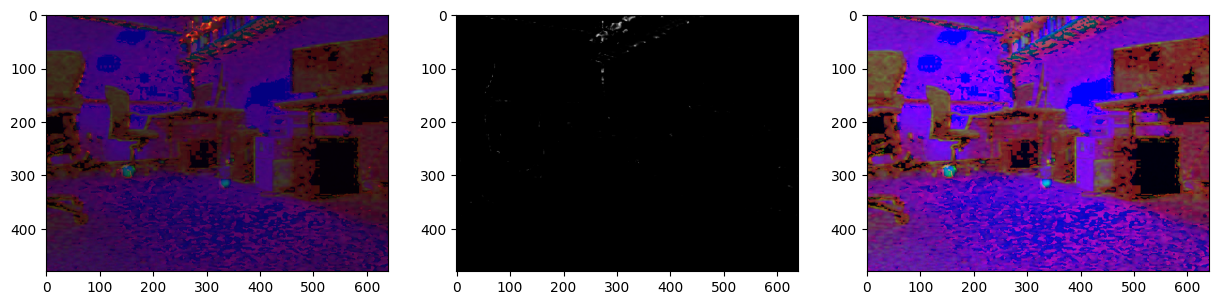

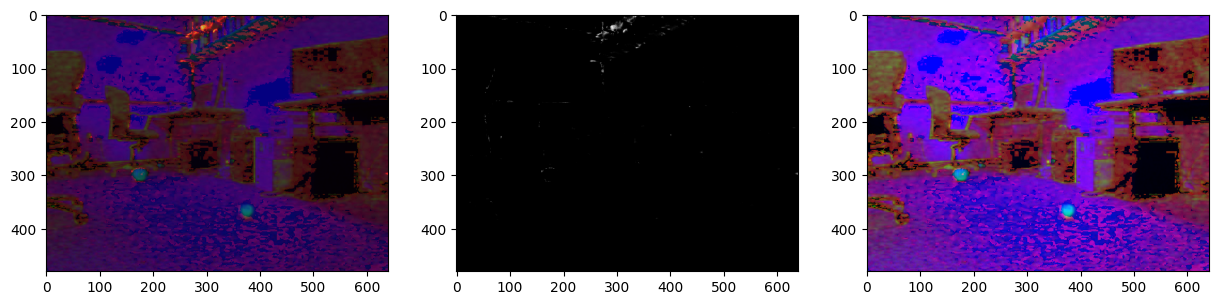

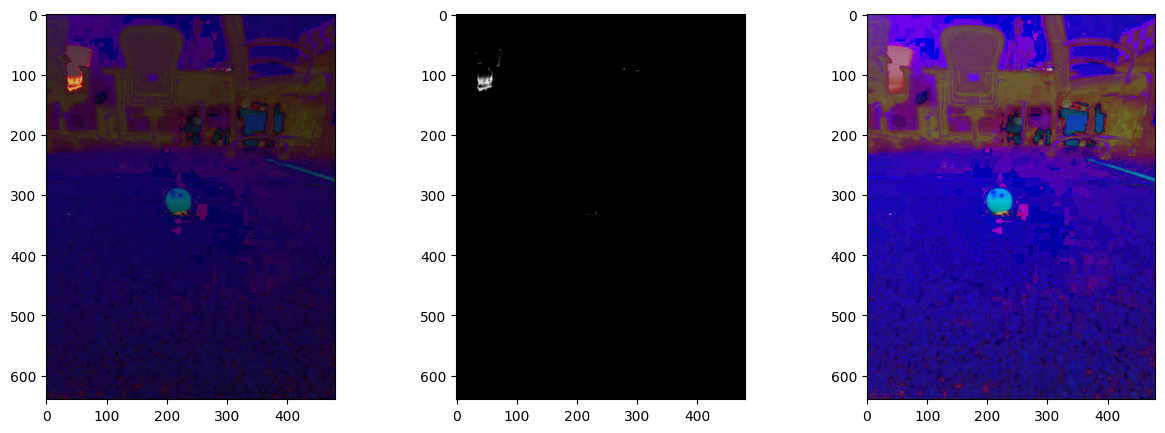

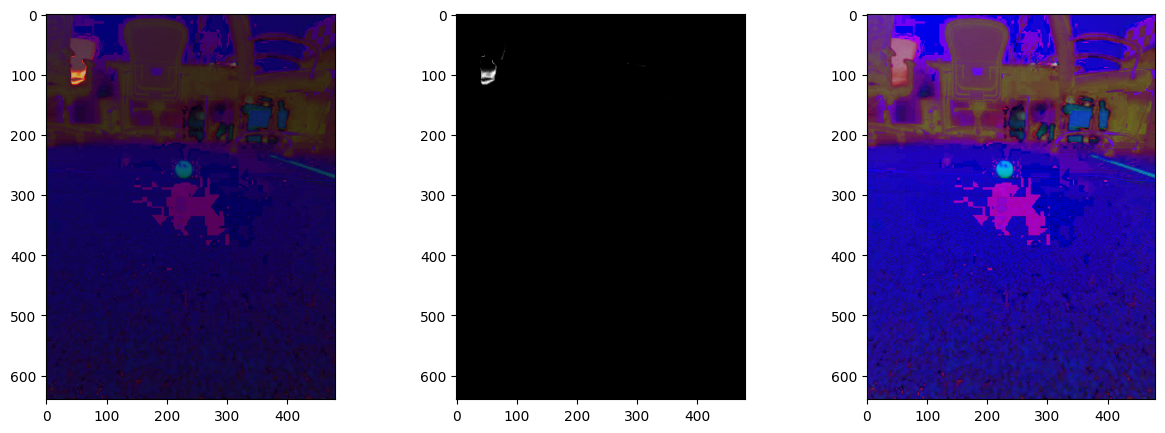

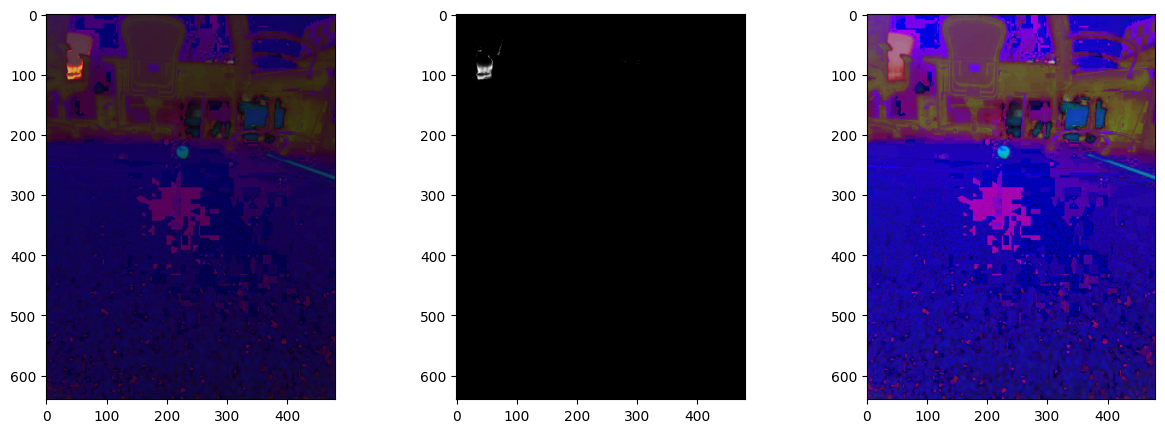

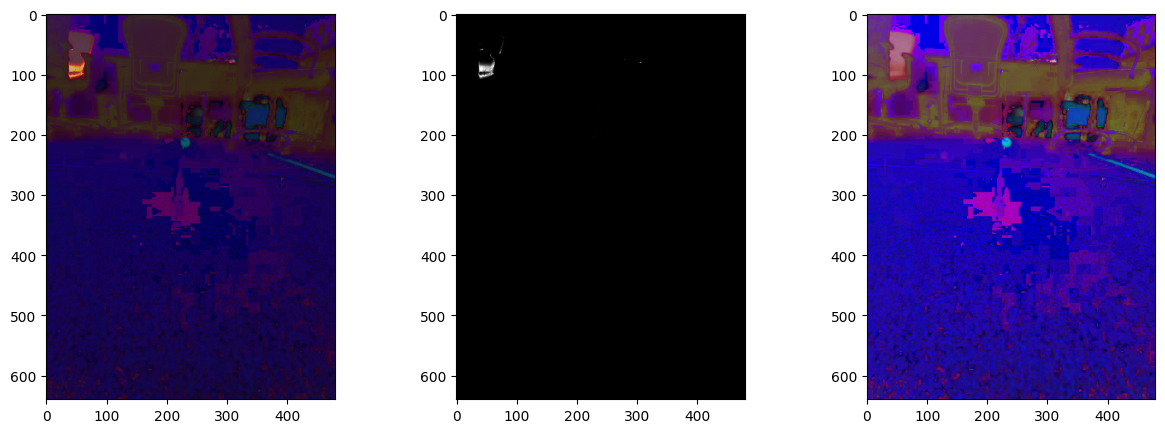

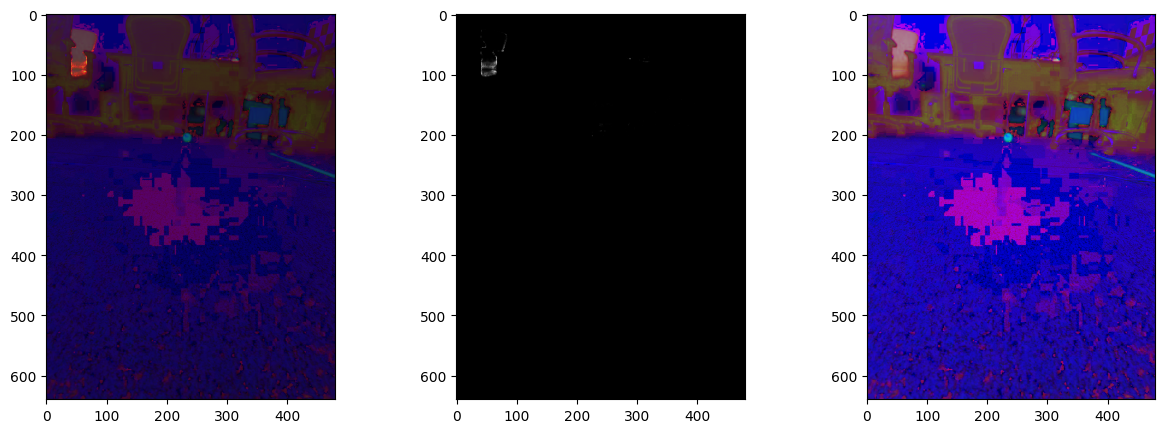

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit

train = []

for image in os.listdir('./train_images'):
    img = cv2.imread('./train_images/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    train.append(img)

train = np.array(train)

orange = []

for img in train:
    lower = np.array([150, 20, 0]) 
    upper = np.array([255, 240, 100]) 
    # lower = np.array([5, 50, 50]) 
    # upper = np.array([15, 255, 255])
    mask = cv2.inRange(img, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)
    orange.append(result)

# for i in range(len(orange)):
#     plt.figure(figsize=(9,3))
#     plt.subplot(131)
#     plt.imshow(train[i])
#     plt.subplot(132)
#     plt.imshow(orange[i])
#     plt.show()

orange = np.array(orange)
# print(orange.shape)
flattened = orange.reshape(-1, 3) #23 images of 480x640 pixels = 737280 pixels and then 3 channels RGB
flattened = flattened[flattened[:, 0] != 0] | flattened[flattened[:, 1] != 0] | flattened[flattened[:, 2] != 0] #remove black pixels because they are not orange
# print(flattened.shape)

mean = np.mean(flattened, axis=0)
cov = np.cov(flattened.T)

def pdf(x, mean, cov):
    x = x - mean
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    norm = 1.0 / ((2 * np.pi)**(3/2) * np.sqrt(det))
    exp = np.exp(-0.5 * np.dot(x.T, np.dot(inv, x)))
    pdf = norm * exp
    return pdf

threshold = 0.000000000001
prior = 0.25

def detector(image, mean, cov, threshold, prior):
    original_shape = image.shape
    image = image.reshape(-1, 3)
    pdf_values = np.apply_along_axis(pdf, 1, image, mean, cov)
    probability = (pdf_values * prior)
    #probability[probability < threshold] = 0
    return probability.reshape(original_shape[:2])

for image in os.listdir('./test_images'):
    img_arr = []
    img = cv2.imread('./test_images/' + image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    detected = detector(img, mean, cov, threshold, prior)
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(img)
    plt.imshow(detected, cmap='hot', alpha=0.5)
    plt.subplot(132)
    plt.imshow(detected, cmap='gray')
    plt.subplot(133)
    plt.imshow(img)
    plt.show()
    img_arr.append(detected)


2. Write Python code to cluster the orange ball using [Gaussian Mixture Model](https://cmsc426.github.io/colorseg/#gmm) [40 points] and estimate the [distance](https://cmsc426.github.io/colorseg/#distest) to the ball [20 points]. Also, plot all the GMM ellipsoids [10 points].


You are NOT allowed to use any built-in Python package(s) like *sklearn.mixture.GaussianMixture* for GMM. To help you with code implementation, we have given the pseudocode :-)

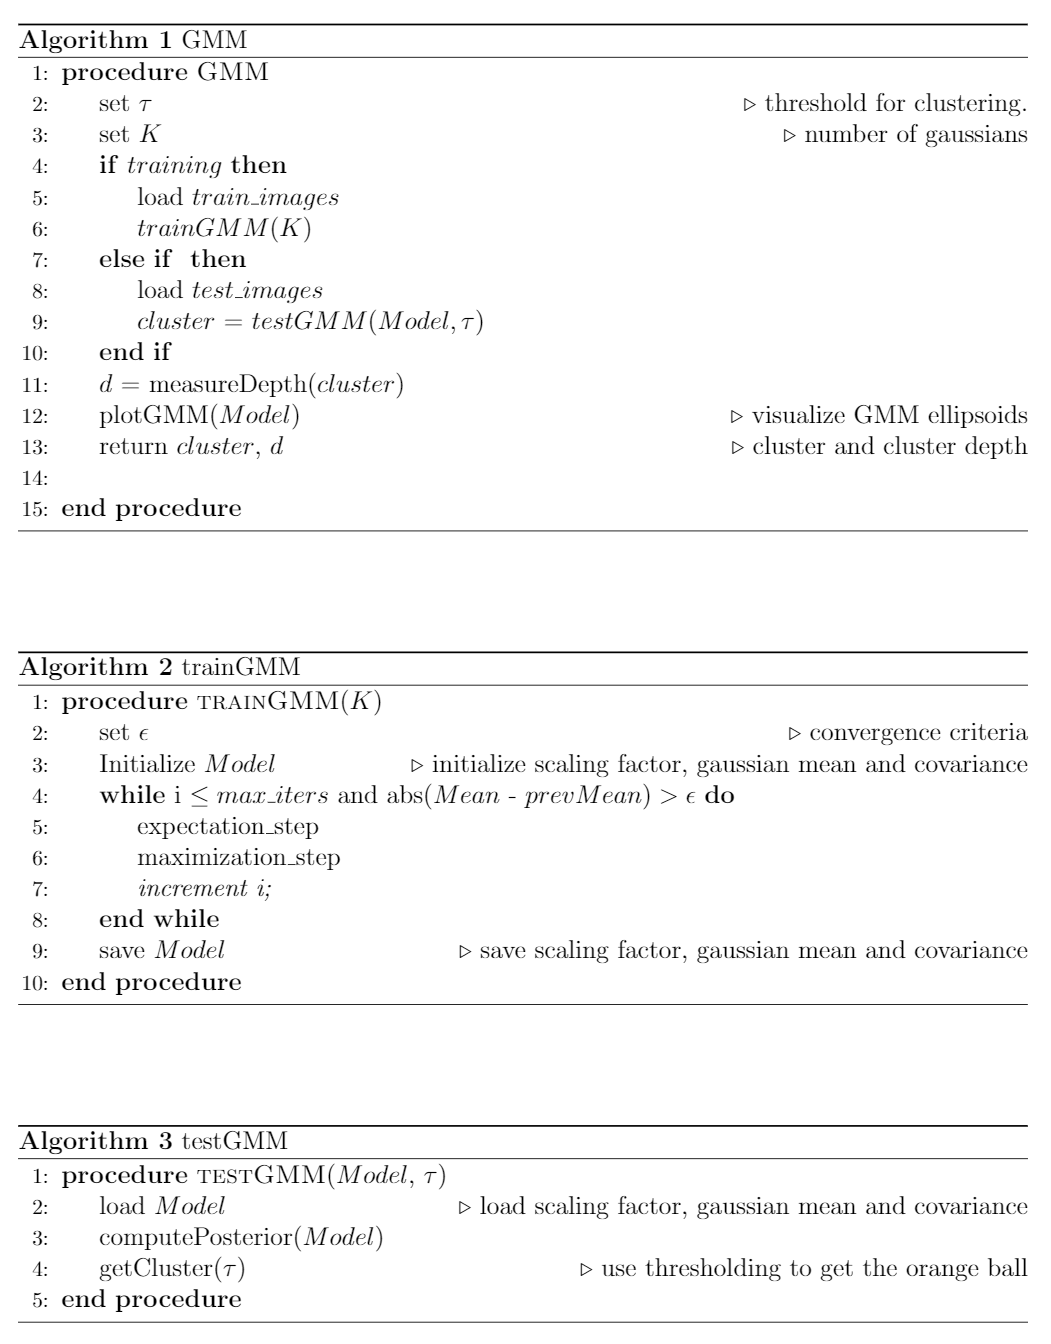

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit

In [48]:
def gaussian_pdf(x, mean, cov):
    d = len(mean)  # dimensionality of the data point
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)

    norm_const = 1.0 / ((2 * np.pi) ** (d / 2) * cov_det ** 0.5)
    x_mu = x - mean
    result = np.exp(-0.5 * np.dot(np.dot(x_mu.T, cov_inv), x_mu))

    return norm_const * result

def mean_update(data, resp):
  N, K = resp.shape # assign values
  means = np.zeros((K, data.shape[1])) # second parameter - dimensionality of each data point

  for i in range(K):
    sum = np.sum(resp[:, i].reshape(-1, 1)*data)
    #updating means sum
    means[i] = sum / np.sum(resp[:, i])

  return means

def update_variance(data, means, resp):
  N, K = resp.shape
  d = data.shape[1]  # number of features
  cov = np.zeros((K, d, d))  # initialize covariance matrices for K clusters

  for i in range(K):  # calculate weighted covariance for cluster i
      diff = data - means[i]
      weighted_diff = resp[:, i].reshape(-1, 1) * diff
      cov[i] = np.dot(weighted_diff.T, diff) / np.sum(resp[:, i])

  return cov

def update_weight(resp):
  return np.sum(resp, axis=0) / resp.shape[0]

def expectation_step(data, pi, means, cov):
    K = len(pi)
    N = data.shape[0]

    resp = np.zeros((N, K))

    pdf_values = np.zeros((N, K))
    for k in range(K):
        pdf_values[:, k] = np.apply_along_axis(multivariate_normal.pdf, 1, data, means[k], cov[k])

    print(pdf_values)
    resp = pi * pdf_values
    resp /= resp.sum(axis=1, keepdims=True)
    
    return resp


def maximization_step(data, resp):
  means = mean_update(data, resp)
  cov = update_variance(data, means, resp)
  weight = update_weight(resp)
  return means, cov, weight

def compute_likelihood_vectorized(pixels, means, covariances):
    K = len(means)
    likelihoods = np.zeros((pixels.shape[0], K))
    #print(likelihoods.shape)
    for i in range(K):
        #print(pixels.shape, means[i].shape, covariances[i].shape)
        likelihoods[:, i] = np.apply_along_axis(gaussian_pdf, 1, pixels, mean=means[i], cov=covariances[i])
    return likelihoods


def compute_posterior_vectorized(pixels, scalars, means, covariances):
    likelihoods = compute_likelihood_vectorized(pixels, means, covariances)
    weighted_likelihoods = scalars * likelihoods
    return weighted_likelihoods / np.sum(weighted_likelihoods, axis=1, keepdims=True)

In [59]:
def trainGMM(K, data):
  #pass
# TODO: Set convergence criteria and initialize scaling factor, gaussian mean and covariance
  # '''Enter your code here'''
  epsilon = 1e-6  # fix later

  # initialize scalars - fix later
  weights = np.ones(K) / K # taken from piazza @84
  means = np.random.randn(K, 3)  # K means for 3D data

  data = data.reshape(-1, 3)
  covariances = np.array([np.eye(3)] * K)  # K identity covariance matrices for 3D data

  prev_means = np.zeros_like(means) # init previous means

  max_iters = 100

  i = 0  # Iteration counter
  print("Initial", weights, covariances, means)

# TODO: Main training algorithm (EM algorithm)
  while i < max_iters and np.all(np.absolute(means - prev_means) > epsilon):
    print("interation: ", i)
    prev_means = means.copy()

    responsibilities = expectation_step(data, weights, means, covariances) # E
    print(responsibilities)
    means, covariances, weights = maximization_step(data, responsibilities) # M

    # Increment iteration counter
    i += 1
  scalars = weights
  return scalars, means, covariances

def testGMM(Model_parameters,threshold,prior):
  scalars, means, covariances = Model_parameters
  K = len(scalars)  # number of Gaussian components

  # TODO: Read training images (using these as test images)
  train_image_folder = './train_images'
  test_image_folder = './test_images'
  result_folder = './result_images'
  if not os.path.exists(result_folder):
      os.makedirs(result_folder)

  images = [f for f in os.listdir(test_image_folder) if f.endswith('.jpg')]

  cluster_parameters = []

  # TODO: Main testing loop over all training images and use thresholding to get the orange ball
  for image_name in images:
      img = cv2.imread(os.path.join(test_image_folder, image_name))
      img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      height, width, _ = img_rgb.shape
      pixels = img_rgb.reshape((-1, 3))


      posteriors = compute_posterior_vectorized(pixels, scalars, means, covariances)
      segmentation_map = posteriors[:, 0].reshape((height, width))

      # Threshold to get the orange ball
      threshold = 0.8  # Adjust this value based on your specific case
      binary_map = (segmentation_map > threshold).astype(np.uint8) * 255

      contours, _ = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      if contours:
          largest_contour = max(contours, key=cv2.contourArea)
          ((x, y), radius) = cv2.minEnclosingCircle(largest_contour)
          cluster_parameters.append((x, y, radius))

      # TODO: Saving predictions to the result folder
      plt.figure(figsize=(15, 5))
      plt.subplot(131)
      plt.imshow(img_rgb)
      plt.title('Original Image')
      plt.axis('off')
      plt.subplot(132)
      plt.imshow(segmentation_map, cmap='hot')
      plt.title('Posterior Probability Map')
      plt.axis('off')
      plt.subplot(133)
      plt.imshow(binary_map, cmap='gray')
      plt.title('Segmented Image')
      plt.axis('off')
      plt.savefig(os.path.join(result_folder, f'segmented_{image_name}'))
      plt.close()

  print("Segmentation complete. Results saved in the result folder.")
  return cluster_parameters

def measureDepth(cluster_parameters):
  radii = np.array([params[2] for params in cluster_parameters])
  print("Radii:", radii)

  # Sort radii in descending order (larger radius = closer object)
  sorted_indices = np.argsort(radii)[::-1]
  sorted_radii = radii[sorted_indices]

  # Create relative distances (1 for closest, increasing for farther)
  relative_distances = np.arange(1, len(radii) + 1)

  # Define the inverse model function
  def inverse_model(x, a, b):
      return a / (x + b)

  # Fit the model to our data
  popt, pcov = curve_fit(inverse_model, relative_distances, sorted_radii, p0=[np.max(radii), 1], bounds=([0, 0], [np.inf, np.inf]))

  # Extract the fitted parameters
  a, b = popt
  print("Fitted parameters: a =", a, "b =", b)

  # Function to estimate relative distance based on radius
  def estimate_relative_distance(radius):
      return (a / radius) - b

  # Estimate relative distances for all balls
  estimated_distances = [estimate_relative_distance(radius) for radius in radii]

  # Normalize estimated distances to be between 1 and len(radii)
  min_dist, max_dist = min(estimated_distances), max(estimated_distances)
  normalized_distances = 1 + (len(radii) - 1) * (np.array(estimated_distances) - min_dist) / (max_dist - min_dist)

  # Sort the normalized distances to match the original order of radii
  final_distances = normalized_distances[np.argsort(sorted_indices)]

  print("Estimated relative distances:", final_distances)
  return final_distances.tolist()

  '''
  radii = np.array([params[2] for params in cluster_parameters])

  relative_distances = np.arange(1, len(radii) + 1)
  print("Relative distances:", relative_distances)

  # Define the inverse square model function
  def inverse_square_model(r, a, b):
      return a / np.sqrt(r - b)
  
  def inverse_model(d, a, b):
        return a / (d - b)

  # Fit the model to our data
  popt, _ = curve_fit(inverse_model, relative_distances, radii) # swap x and y

  # Extract the fitted parameters
  a, b = popt
  print("Fitted parameters: a =", a, "b =", b)

  # Function to estimate distance based on radius
  def estimate_distance(radius):
      return a / radius + b
      #return (a / (radius - b))**2

  # Estimate distances for all balls
  distances = [estimate_distance(radius) for radius in radii]

  return distances
  '''

def plotGMM(Model_parameters,distance):
  print("Plotting the GMM model")
  scalars, means, covariances = Model_parameters
  K = len(scalars)  # number of Gaussian components

  # Plot the GMM model
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(flattened[:, 0], flattened[:, 1], flattened[:, 2], c='b', marker='o', label='Data points')

  # Plot the Gaussian components

  for i in range(K):
      mean = means[i]
      covariance = covariances[i]
      x, y, z = np.random.multivariate_normal(mean, covariance, 5000).T
      ax.scatter(x, y, z, marker='.', label=f'Gaussian {i + 1}')

  ax.set_xlabel('Red')

  ax.set_ylabel('Green')

  ax.set_zlabel('Blue')

  ax.set_title('Gaussian Mixture Model')

  plt.legend()

  plt.show()
  


In [ ]:
# Main function (Algorithm 1 in the pseudocode above)




# -Write Python code to cluster the orange ball using Gaussian Mixture Model [40 points].

# -Estimate the distance to the ball [20 points].

# -Plot all the GMM ellipsoids [10 points].





# TODO: Import all python packages you need


threshold = 0.5 # Threshold for clustering (Set it to an appropriate value)
K = 2 # Number of gaussians (Set it to an appropriate value)

mode_flag = 0 # (Set it to 0 for training, 1 for testing)

scalars = None
means = None
covariances = None

if mode_flag == 0:

  train = []

  for image in os.listdir('./train_images'):
      img = cv2.imread('./train_images/' + image)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      train.append(img)

  train = np.array(train)

  for i in range(8):
     scalars, means, covariances = trainGMM(K, train[8])
else:
  cluster_parameters = testGMM((scalars, means, covariances),threshold, prior)
  print(cluster_parameters)
  distance = measureDepth(cluster_parameters)
  plotGMM((means, covariances, scalars), distance)


In [60]:
cluster_parameters = testGMM((scalars, means, covariances),threshold, 0)
print(cluster_parameters)
distance = measureDepth(cluster_parameters)
print(distance)
#plotGMM((means, covariances, scalars), distance)#

/var/folders/t4/whgx7y7x6nj0p58dc2r8wb1r0000gn/T/ipykernel_70589/3336546127.py:78: RuntimeWarning: invalid value encountered in divide
  return weighted_likelihoods / np.sum(weighted_likelihoods, axis=1, keepdims=True)


KeyboardInterrupt: 

In [23]:
def plotGMM(Model_parameters,distance):
  print("Plotting the GMM model")
  scalars, means, covariances = Model_parameters
  K = len(scalars)  # number of Gaussian components

  # Plot the GMM model
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(flattened[:, 0], flattened[:, 1], flattened[:, 2], c='b', marker='o', label='Data points')

  # Plot the Gaussian components

  for i in range(K):
      mean = means[i]
      covariance = covariances[i]
      x, y, z = np.random.multivariate_normal(mean, covariance, 5000).T
      ax.scatter(x, y, z, marker='.', label=f'Gaussian {i + 1}')

  ax.set_xlabel('Red')

  ax.set_ylabel('Green')

  ax.set_zlabel('Blue')

  ax.set_title('Gaussian Mixture Model')

  plt.legend()

  plt.show()

# Video Lecture
Click [here](https://www.youtube.com/watch?v=D5AcaFMY_BI) for a video lecture to help you better understand the project.

## Report
For each section of the project, explain briefly what you did, and describe any interesting problems you encountered and/or solutions you implemented. You must include the following details in your writeup:

- Your choice of color space, initialization method and number of gaussians in the GMM
- Explain why GMM is better than single gaussian
- Present your distance estimate and cluster segmentation results for each test image
- Explain strengths and limitations of your algorithm. Also, explain why the algorithm failed on some test images

As usual, your report must be full English sentences, not commented code. There is a word limit of 1500 words and no minimum length requirement.

## ***add your report here***


# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj1.pdf**. For example, xyz123_proj1.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to ELMS(Canvas).**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2023 website.

In [51]:
#USEFUL CODE TO TEST

import os
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture

def trainGMM(train_dir, k):
    """
    Train a GMM on the orange pixels from training images using scikit-learn.
    :param train_dir: Directory containing training images
    :param K: Number of Gaussian components
    :return: Trained GMM model
    """
    image_files = [f for f in os.listdir(train_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    orange_pixels = []
    ans = []

    for image_file in image_files:
        image_path = os.path.join(train_dir, image_file)
        print(f"Processing: {image_path}")

        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Unable to read image {image_path}")
            continue

        try:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except cv2.error as e:
            print(f"Error converting color space for {image_path}: {str(e)}")
            continue

        # Simple color thresholding to get orange pixels

        # lower_orange = np.array([212, 151, 23])
        # upper_orange = np.array([255, 200, 100])

        lower_orange = np.array([225, 150, 80])
        upper_orange = np.array([255, 200, 100])

        # lower_orange = np.array([200, 85, 0])    # Lower bound in RGB
        # upper_orange = np.array([255, 165, 50])  # Upper bound in RGB


        mask = cv2.inRange(img_rgb, lower_orange, upper_orange)
        orange_pixels.extend(img_rgb[mask > 0])
        ans.extend(img_rgb)

    if not orange_pixels:
        raise ValueError("No orange pixels found in any of the images.")

    ans = np.array(ans)
    orange_pixels = np.array(orange_pixels)
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(orange_pixels)
    return gmm

gmm = trainGMM("train_images", 2)
scalars = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_
print("GMM trained successfully")
print(scalars)

Processing: train_images/176.jpg
Processing: train_images/200.jpg
Processing: train_images/76.jpg
Processing: train_images/216.jpg
Processing: train_images/160.jpg
Processing: train_images/99.jpg
Processing: train_images/114.jpg
Processing: train_images/248.jpg
Processing: train_images/264.jpg
Processing: train_images/106.jpg
Processing: train_images/256.jpg
Processing: train_images/280.jpg
Processing: train_images/121.jpg
Processing: train_images/137.jpg
Processing: train_images/208.jpg
Processing: train_images/168.jpg
Processing: train_images/223.jpg
Processing: train_images/68.jpg
Processing: train_images/192.jpg
Processing: train_images/144.jpg
Processing: train_images/152.jpg
Processing: train_images/231.jpg
Processing: train_images/91.jpg
GMM trained successfully
[0.66535561 0.33464439]
